## Policy Iteration (2 step)
- Policy Evaluation
- Policy Improvement

In [1]:
import gym
%matplotlib inline

In [2]:
env = gym.make("FrozenLake8x8-v0")

obs_space = env.observation_space
n_state = obs_space.n
print("Observation space's total states :", n_state)

act_space = env.action_space
n_act = act_space.n
print("Action space's total actions :", n_act)

# Transition Matrix for FrozenLake
P = env.unwrapped.P
env.render() # show

Observation space's total states : 64
Action space's total actions : 4

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


### Define functions step by step
#### Initial Policy : $\pi_0 (\centerdot| s)$

Initial Policy Distribution : 



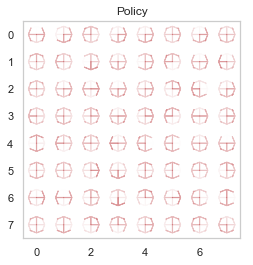

[[0.371 0.175 0.451 0.003]
 [0.065 0.423 0.377 0.135]
 [0.317 0.219 0.152 0.312]
 [0.156 0.332 0.442 0.07 ]
 [0.163 0.386 0.372 0.079]
 [0.223 0.195 0.362 0.22 ]
 [0.157 0.343 0.465 0.036]
 [0.262 0.289 0.274 0.175]
 [0.174 0.245 0.209 0.373]
 [0.381 0.164 0.216 0.238]
 [0.016 0.507 0.235 0.242]
 [0.277 0.329 0.295 0.098]
 [0.039 0.327 0.358 0.276]
 [0.438 0.06  0.168 0.335]
 [0.332 0.236 0.404 0.027]
 [0.502 0.213 0.245 0.039]
 [0.281 0.203 0.228 0.288]
 [0.262 0.266 0.388 0.084]
 [0.367 0.093 0.493 0.047]
 [0.271 0.335 0.371 0.023]
 [0.197 0.262 0.386 0.155]
 [0.118 0.097 0.427 0.358]
 [0.461 0.371 0.02  0.147]
 [0.154 0.345 0.39  0.111]
 [0.364 0.238 0.167 0.232]
 [0.253 0.333 0.151 0.264]
 [0.151 0.222 0.32  0.306]
 [0.295 0.246 0.384 0.075]
 [0.104 0.18  0.41  0.306]
 [0.407 0.085 0.121 0.386]
 [0.375 0.134 0.385 0.107]
 [0.121 0.249 0.367 0.262]
 [0.03  0.438 0.07  0.462]
 [0.428 0.074 0.265 0.233]
 [0.318 0.171 0.26  0.251]
 [0.502 0.126 0.313 0.059]
 [0.364 0.339 0.004 0.293]
 

In [3]:
def plot_policy(policy):
    plt.figure(num=0)
    plt.imshow(np.ones((8,8,3)))
    plt.title("Policy")  
    arr_len = 0.2
    for i in range(8):
        for j in range(8):
            s = i*8+j
            if policy[s][0]> 0:
                plt.arrow(j,i,-arr_len,0,color="r",alpha=policy[s][0],width=0.01,head_width=0.5,head_length=0.1,overhang=1)
            if policy[s][1]> 0:
                plt.arrow(j,i,0,arr_len,color="r",alpha=policy[s][1],width=0.01,head_width=0.5,head_length=0.1,overhang=1)
            if policy[s][2]> 0:
                plt.arrow(j,i,arr_len,0,color="r",alpha=policy[s][2],width=0.01,head_width=0.5,head_length=0.1,overhang=1)
            if policy[s][3]> 0:
                plt.arrow(j,i,0,-arr_len,color="r",alpha=policy[s][3],width=0.01,head_width=0.5,head_length=0.1,overhang=1)
    plt.grid(False)
    plt.show()
    
policy = np.random.uniform(size=(n_state,n_act)) # 0~1사이의 숫자 random sampling
policy = policy/np.sum(policy, axis=1, keepdims=True) # 합이 1이 되도록 만들어준다.

np.set_printoptions(precision=3, suppress=True)
print("Initial Policy Distribution : \n")
plot_policy(policy)
print(policy)

### Policy Evaluation
: policy($\pi$)를 고정하고, 전체 state의 value function을 계산한다. <br>
: 아래의 식을 활용 <br>
$$V_{\pi}(s) = \sum_a \pi(a|s)\sum_{s'} [r(s,a,s') + \gamma V_{\pi}(s')]P(s'|s,a)$$

In [8]:
P.keys() # all state

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63])

In [9]:
P[0].keys() # all action in state 0

dict_keys([0, 1, 2, 3])

In [10]:
P[0][1]

[(0.3333333333333333, 0, 0.0, False),
 (0.3333333333333333, 8, 0.0, False),
 (0.3333333333333333, 1, 0.0, False)]

Policy Evaluation for random policy 

Value of current policy


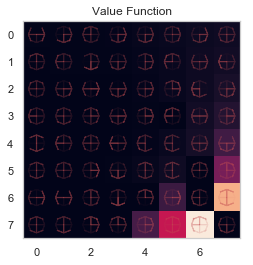

In [13]:
def policy_evaluation(env, policy, gamma=0.99, epsilon=1e-6):
    """
    gamma : discount factor
    epsilon : terminal condition(이것보다 작아지면 break하여 optimal추출)
    """
    
    # Extract environment information
    obs_space = env.observation_space
    n_state = obs_space.n
    P = env.unwrapped.P
    
    # Random initialize the Value (function)
    v = np.random.uniform(size=(n_state,1))
    
    while True:
        v_prime = np.zeros((n_state,))
        for s in P.keys():
            for a in P[s].keys():
                for prob, next_s, reward, done in P[s][a]:
                    v_prime[s] += policy[s][a] * (reward + gamma*v[next_s]) * prob
        
        dist = np.max(np.abs(v-v_prime))
        v = v_prime
        if dist < epsilon:
            break
    return v

def plot_results(policy, value): 
    # policy visualization
    plt.figure(num=0)
    plt.imshow(np.reshape(value,(8,8)))
    plt.title("Value Function")  
    arr_len = 0.2
    for i in range(8):
        for j in range(8):
            s = i*8+j
            if policy[s][0]> 0:
                plt.arrow(j,i,-arr_len,0,color="r",alpha=policy[s][0],width=0.01,head_width=0.5,head_length=0.1,overhang=1)
            if policy[s][1]> 0:
                plt.arrow(j,i,0,arr_len,color="r",alpha=policy[s][1],width=0.01,head_width=0.5,head_length=0.1,overhang=1)
            if policy[s][2]> 0:
                plt.arrow(j,i,arr_len,0,color="r",alpha=policy[s][2],width=0.01,head_width=0.5,head_length=0.1,overhang=1)
            if policy[s][3]> 0:
                plt.arrow(j,i,0,-arr_len,color="r",alpha=policy[s][3],width=0.01,head_width=0.5,head_length=0.1,overhang=1)
    plt.grid(False)
    plt.show()

if __name__=='__main__':
    print("Policy Evaluation for random policy \n")
    value = policy_evaluation(env, policy=policy, gamma=0.99, epsilon=1e-6)
    print("Value of current policy")
    plot_results(policy=policy, value=value)
    
    # policy 초기값 넣어 한번 evaluation하고 시각화

### Policy Improvement
: Policy Evaluation에서 계산된 value가지고, Policy($\pi$)를 업데이트하자.<br>
: 새로운 policy는 greed하게 업데이트된다. <br>

\DeclareMathOperator*{\argmax}{arg\,max}

$$ \\ Q_{\pi_i}(s,a) = \sum_{s'}[r(s,a,s') + \gamma V_{\pi_i}(s')]P(s'|s,a) \\$$
$$\pi_{i+1} = argmax_a Q_{\pi_i}(s,a)$$

Policy improvement 

Improved Policy


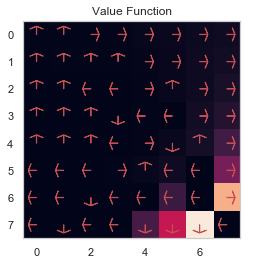

In [14]:
def policy_improvement(env, v, gamma=0.99):
    obs_space = env.observation_space
    n_state = obs_space.n
    act_space = env.action_space
    n_act = act_space.n
    q = np.zeros((n_state,n_act))
    
    for s in P.keys():
        for a in P[s].keys():
            for prob, next_s, reward, done in P[s][a]:
                q[s][a] += (reward + gamma*v[next_s])*prob
                
    policy = np.zeros((n_state, n_act))
    # 모든 state의 expected return(q값)이 제일 큰 action의 probability를 1로 만든다.
    policy[np.arange(n_state), np.argmax(q,axis=1)] = 1 
    
    return policy

if __name__=='__main__':
    print("Policy improvement \n")
    policy = policy_improvement(env, value) # 위에서 선언한 value
    print("Improved Policy")
    plot_results(policy=policy, value=value)

이게 최초 업데이트된 상태의 policy <br>
이제 이걸 iteration시킨다.(반복)

### Policy Iteration
Policy iteration algorithm consists of four steps: <br>
<br>
(1) Initial policy distribution is randomly initialized <br>
<br>
(2) Value function for current policy is computed by policy evaluation <br>
<br>
(3) Policy distribution is greedily updated using value function from (2) <br>
<br>
(4) If policy distribution doesn't change, then stop. Othrewise, repeat (1) ~ (3) <br>

Policy Iteration
Computation Time : 7.13


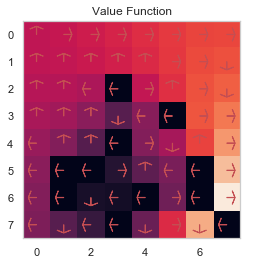

In [15]:
def policy_iteration(env):
    policy = np.random.uniform(size=(n_state, n_act))
    policy = policy / np.sum(policy, axis=1, keepdims=True)
    
    while True:
        value = policy_evaluation(env, policy)
        policy_prime = policy_improvement(env, value)
        
        if (policy == policy_prime).all(): # it means 'nothing changed'
            break
        policy = policy_prime # update new policy
    
    return policy, value

if __name__=='__main__':
    print("Policy Iteration")
    import time
    start = time.time()
    policy, value = policy_iteration(env)
    print("Computation Time : %.2f"%(time.time() - start))
    plot_results(policy, value)

### Run Optimal Policy

In [16]:
obs = env.reset()
for t in range(10000):
    print('t = %d'%t)
    env.render()
    print('')
    action = np.random.choice(n_act, 1, p=policy[obs][:])[0]
    next_obs, reward, done, info = env.step(action)
    obs = next_obs
    if done:
        break
env.render()
env.close()

t = 0

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 1
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 2
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 3
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 4
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 5
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 6
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 7
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 8
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 9
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 10
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 11
  (Right)
SFFFFFFF
FFFFFFFF
FFF